# Installing wandb

In [11]:
!pip install --upgrade wandb

^C


# Importing Libraries

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import wandb
import os
from typing import Any, Dict, List
import copy
import random
import wandb
import numpy as np
import matplotlib.pyplot as plt

#Libraries for mobolity
from collections import Counter
import random
import numpy as np
import logging
import clustering
import clients
import numpy
from scipy.spatial.distance import cdist
from mobility import gauss_markov, reference_point_group, \
    tvc, truncated_levy_walk, random_direction, random_waypoint, random_walk
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import Leach
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

#Clustering Library
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import kmean_clustering

#custom library
import custom_model
import server



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#os.environ["WANDB_API_KEY"] = "183c1a6a36cbdf0405f5baacb72690845ecc8573"

# Importing dataset
## validating dataset structure

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='cifar_data', train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='cifar_data', train=False, download=True,transform=transform)

print(trainset)
print(testset)

trainloader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=500,
                                           shuffle=True)

print(str("\ntrainset datatype: ")+str((type(trainset))))
print(str("testset datatype: ")+str((type(testset))))


print(str("\nLabel in cifar10: ")+str(np.unique([trainset[i][1] for i in range(len(trainset))])))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(classes)


def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:1s}' for j in range(16)))

# # This is for iid data
# trainloader = torch.utils.data.DataLoader(trainset, 
#                                           batch_size=500,
#                                           shuffle=True)
testloader = torch.utils.data.DataLoader(testset,
                                        batch_size=100,
                                        shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

trainset datatype: <class 'torchvision.datasets.cifar.CIFAR10'>
testset datatype: <class 'torchvision.datasets.cifar.CIFAR10'>

Label in cifar10: [0 1 2 3 4 5 6 7 8 9]
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Initialising parameters

In [11]:
n_client = 30
n_leader = int(n_client * 0.1)
chosen_prob = 0.8
local_batch_size = 32
local_epochs = 5

epochs = 5
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD
optimizer_conf = dict(
    lr=0.001,
    momentum=0.9
)



model = custom_model.Net().to(device)
print(str("Model structure: \n")+str(model))

server_list: List[server.Server] = []

leaderStep = int(n_client/n_leader)

Model structure: 
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Mobility
## Assigning coordinates to nodes & creating clusters

Coordinates generated: 
[[18.39839891 26.79646631]
 [95.03824448 61.86341421]
 [90.38934082 26.38757339]
 [53.34519328 56.74059427]
 [39.41817051 10.90634014]
 [28.42918166 56.92422588]
 [80.42768    61.58491742]
 [32.02827993 24.42435152]
 [85.68114019 41.30603091]
 [86.33075913 25.14261621]
 [76.18378956 65.86985846]
 [47.72839356 66.39393991]
 [20.25853068 91.03235363]
 [18.43027994 95.53617346]
 [35.96631085 12.61518217]
 [61.78414449  2.45425339]
 [76.19556261 69.10506403]
 [62.37692549  1.44829415]
 [38.21671773 20.38841057]
 [63.93959551 86.84645104]
 [47.15005807  2.66312755]
 [10.8449529  57.94976435]
 [73.43714486  5.15827358]
 [47.86458779 90.63239674]
 [52.63976174 89.99001038]
 [13.13148564 51.57567912]
 [56.58021295 76.97139824]
 [69.62869179 99.03848919]
 [49.14497882 78.8885162 ]
 [18.26780863 32.33673877]]

Label: 
[3 0 0 4 2 3 0 2 0 0 4 4 1 1 2 2 4 2 2 4 2 3 2 4 4 3 4 4 4 3]


C:\Users\lloflo\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


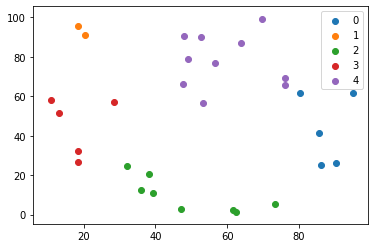


Label: 
[3 0 0 2 1 3 0 1 0 0 0 2 4 4 1 1 0 1 1 2 1 3 1 2 2 3 2 2 2 3]


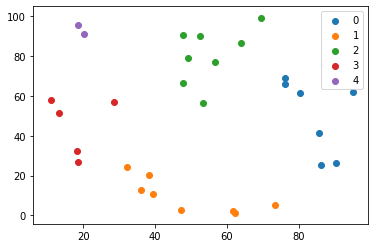

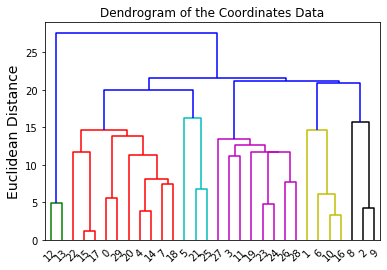

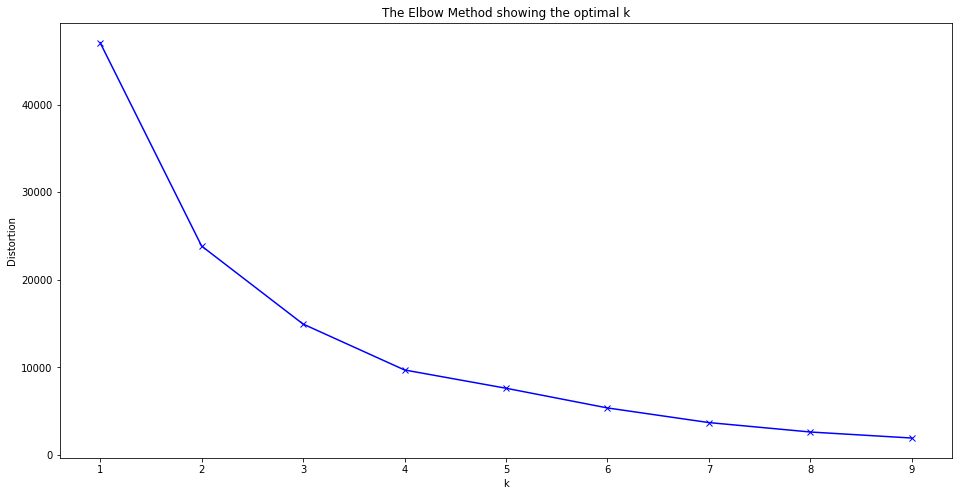

labels of clusters: [0 1 1 2 0 2 1 0 1 1 1 2 2 2 0 0 1 0 0 2 0 2 0 2 2 2 2 2 2 0]


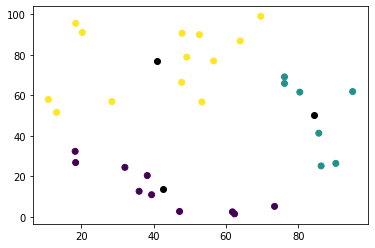

In [12]:
classes_pair = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]

data_label = np.array(trainset.targets)

nr_nodes = int(n_client)

logger = logging.getLogger("vanet")

step = 0
np.random.seed(0xffff)

# simulation area (units)
MAX_X, MAX_Y = 100, 100

# max and min velocity
MIN_V, MAX_V = 0.1, 1.

# max waiting time
MAX_WT = 100.

# number of steps to ignore before start plotting
STEPS_TO_IGNORE = 10000

# set this to true if you want to calculate node contacts
CALCULATE_CONTACTS = False

# if calculating contacts, this is the range to be used
# (if a distance(a,b) < RANGE, then there is a contact betwen a and b)
RANGE = 1.

#rw = random_walk(nr_nodes, dimensions=(MAX_X, MAX_Y))
#rw = gauss_markov(nr_nodes, dimensions=(MAX_X, MAX_Y))
#rw = truncated_levy_walk(nr_nodes, dimensions=(MAX_X, MAX_Y))
rw = reference_point_group(nr_nodes, dimensions=(MAX_X, MAX_Y),velocity=(5.0, 10.0))

cluster = clustering.Cluster(nr_nodes,
                             step,MAX_X, 
                             MAX_Y,MIN_V, 
                             MAX_V,MAX_WT,
                             STEPS_TO_IGNORE,
                             CALCULATE_CONTACTS,
                             RANGE,rw)

coordinate = cluster.coord(rw)
print(str("Coordinates generated: \n") + str(coordinate))

#AffinityPropagation clustering
affinity_clustering = coordinate 
affinity_model = AffinityPropagation(damping=0.9)
affinity_model.fit(affinity_clustering)
yhat = affinity_model.predict(affinity_clustering)
clusters = unique(yhat)
print(str("\nLabel: \n")+str(affinity_model.labels_))
# create scatter plot for samples from each cluster
for clust in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == clust)
    # create scatter of these samples
    plt.scatter(affinity_clustering[row_ix, 0], affinity_clustering[row_ix, 1], label = clust)
# show the plot
plt.legend()
plt.show()


agglomerative_cluster = coordinate 
# define the model
agglomerative_model = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat = agglomerative_model.fit_predict(agglomerative_cluster)
# retrieve unique clusters
clusters = unique(yhat)
print(str("\nLabel: \n")+str(agglomerative_model.labels_))
# create scatter plot for samples from each cluster
for clust in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == clust)
    # create scatter of these samples
    plt.scatter(agglomerative_cluster[row_ix, 0], agglomerative_cluster[row_ix, 1], label = clust)
# show the plot
plt.legend()
plt.show()

#Dendrogram plot for Agglomerative clustering
den = dendrogram(linkage(coordinate, method='single'))
plt.ylabel('Euclidean Distance', fontsize = 14)
plt.title('Dendrogram of the Coordinates Data')
plt.show()

#KMeans Clustering
kmean_cluster = kmean_clustering.Kmeans_cluster(coordinate, n_leader, n_leader, [], None, [], n_client)
best_k = kmean_cluster.getElbowCurve(coordinate)
kmeans = kmean_cluster.createCluster(3,coordinate)
cluster_coords = kmean_cluster.initiaiseClusterCoordinates(kmeans)
#print(str("cluster_coords ")+str(cluster_coords))
client_list = kmean_cluster.getClientList(cluster_coords)
cluster_coords = kmean_cluster.fillingNoneValue(cluster_coords)         



In [13]:
servers = []

for i in range(0,n_leader):
    server_list = server.Server(
        model=model,
        loss=criteria,
        optimizer=optimizer,
        n_client=client_list[i],
        #n_leader=n_leader,
        chosen_prob=chosen_prob,
        optimizer_conf=optimizer_conf,
        local_batch_size=local_batch_size,
        local_epochs=local_epochs
    )
    servers.append(server_list)
        
def initialiseClientCoordinates(best_k,coordinate,cluster_coords):
    for i in range(int(best_k)):
        #print(str('for server: ') + str(i))
        for j in range(len(coordinate)):
            for k in range(len(cluster_coords[i])):
                if (cluster_coords[i][j] == k):
                    servers[i].client_pool[j].setXCoordinate(coordinate[k][0])
                    servers[i].client_pool[j].setYCoordinate(coordinate[k][1])

        
initialiseClientCoordinates(best_k,coordinate,cluster_coords)

def showClient():
    for i in range(int(best_k)):
        for j in range(client_list[i]):
            print(str('for server: ') + str(i) + str(' client ') + str(j) 
                  + str(' coordinates ') + str(servers[i].client_pool[j].actual_Xcoord) + str(', ') 
                  + str(servers[i].client_pool[j].actual_Ycoord))
            
#showClient()

In [14]:
# # This is for iid data
# for batch_idx, (batch_feature, batch_label) in enumerate(trainloader):
#     server.client_pool[batch_idx].setData(list(zip(batch_feature, batch_label)))


# This is for non-iid data                   
chosen_counter = Counter()
for i in range(len(servers)):
    for _, client in tqdm(enumerate(servers[i].client_pool)):        
        # sample until we have a pair of class with insufficient client owning
        class_pair = random.choice(classes_pair)
        while chosen_counter[class_pair] == 100:
            class_pair = random.choice(classes_pair)

        chosen_counter[class_pair] += 1
        first_class, second_class = class_pair
        first_class_sample_idx = list(np.where(data_label == first_class)[0])
        second_class_sample_idx = list(np.where(data_label == second_class)[0])
        #first_class_sample_idx = list(first_class[0])
        #second_class_sample_idx = list(scond_class[0])

        client_first_class_sample_idx = random.sample(first_class_sample_idx, k=500)
        client_second_class_sample_idx = random.sample(second_class_sample_idx, k=500)
        client_data = []
    
        for i in range(500):
            client_data.append(trainset[client_first_class_sample_idx[i]])
            client_data.append(trainset[client_second_class_sample_idx[i]])

        client.setData(client_data)

10it [00:01,  5.95it/s]
7it [00:01,  4.81it/s]
13it [00:02,  5.30it/s]


# Dynamic nodes clustering

Using matplotlib backend: Qt5Agg
[[17.42016394 26.5889661 ]
 [94.04006623 61.92374819]
 [89.71253018 27.12373056]
 [54.08954697 57.40837986]
 [39.96633874 10.06997205]
 [27.7659834  57.67266965]
 [80.1911557  62.556543  ]
 [32.89005269 24.93164603]
 [84.81116382 40.81293751]
 [85.39121971 25.48505698]
 [76.96751658 66.49096391]
 [46.89258719 65.84491559]
 [20.36837627 90.03840497]
 [18.10568532 94.59032022]
 [36.92539973 12.89828731]
 [61.02971771  1.79786918]
 [76.25688639 68.1069461 ]
 [61.6391847   2.12337825]
 [38.7856348  21.21080547]
 [62.98053555 86.56324793]
 [46.9964143   3.65125385]
 [10.13873469 57.24177011]
 [72.58242515  5.67736338]
 [47.59829268 91.59628829]
 [51.96938177 89.24799239]
 [12.14893509 51.38968333]
 [57.29852647 77.66711779]
 [69.59667683 99.96202342]
 [49.14372197 79.88851541]
 [18.28739097 33.33654702]]
[[17.85074659 27.49151725]
 [93.52720376 61.0652774 ]
 [90.71144992 27.17019946]
 [55.06385049 57.63361894]
 [40.51738984  9.23550054]
 [27.66309336 58.6673

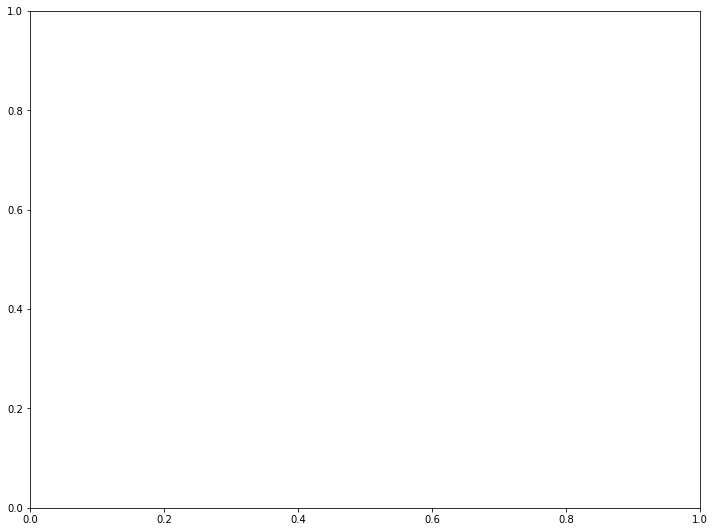

In [15]:
#%matplotlib
#looping process

coordinate_array = []
best_ks = []
cluster_array = []
kmeans_array = []
cluster_coords_array = []

LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'g',
                   2 : 'b',
                   3 : 'y',
                   4 : 'b'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

%matplotlib
from sklearn.cluster import KMeans
plt.ion()
plt.figure(2)
for i in range(epochs):
    coordinates = cluster.coord(rw)
    print(coordinates)
    kmeans = KMeans(n_clusters=3).fit(coordinates)
    plt.scatter(coordinates[:,0],coordinates[:,1], c=label_color)
    plt.show()
    plt.pause(0.3)
    plt.cla()

# Aggregation and propagation of the models

In [16]:
#wandb.init(project="fl", name="CNN_CIFAR_10_noniid")
#print((servers[0].client_pool[0].data))
aggregates = []

    
for i in range(epochs):
    for j in range(len(servers)):
        servers[j].aggregate()
        servers[j].broadcast()
        total_correct = 0
        #with torch.no_grad():
        for _, (test_feature, test_label) in enumerate(testloader):
            test_feature = test_feature.to(device)
            test_label = test_label.to(device)
            y_pred = servers[j].model(test_feature)
            y_pred_decode = torch.argmax(y_pred, dim=1)

            total_correct += y_pred_decode.eq(test_label).sum().item()
            #print(str('total_correct ')+str(total_correct))
        test_acc = total_correct / 10000

        print("Overall acc: {}, overall_loss: {}".format(servers[j].avg_acc, servers[j].avg_loss))
        #wandb.log({"acc": servers[j].avg_acc, "loss": servers[j].avg_loss})
#print(model.conv1.weight.grad)

Original Secret: 3601534403
Shares: (77412, 4675548491), (67338, 4535781815), (88982, 4836070671), (83363, 4758112665), (16753, 3833965525), (3008, 3643267395), (54089, 4351965189), (98302, 4965376351), (24267, 3938214761), (23373, 3925811405)
Reconstructed secret: 3601534403
Client 8: Acc 0.4951171875, Loss: 0.713223559781909
Client 4: Acc 0.5322265625, Loss: 0.6977242026478052


KeyboardInterrupt: 